In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.chdir('/data_hdd1/hassan/projects/fracture/')

In [2]:
import torch, os, torchvision, cv2
import torch.nn as nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mmcv.ops import DeformConv2d
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2, transforms
from torchvision.io import read_image, ImageReadMode
from skimage import exposure
from models.resnet_18_CNN import ResNet18_FasterRCNN
import cv2

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
DEVICE

'cuda'

In [4]:
IMG_DIR_TRAIN = "/data_hdd1/hassan/projects/fracture/data//train/clean/images/"
ANNT_DIR_TRAIN = "/data_hdd1/hassan/projects/fracture/data/train/clean/labels/"

IMG_DIR_VALID = "/data_hdd1/hassan/projects/fracture/data/valid/clean/images/"
ANNT_DIR_VALID = "/data_hdd1/hassan/projects/fracture/data/valid/clean/labels/"

IMG_DIR_TEST = "/data_hdd1/hassan/projects/fracture/data/test/clean/images/"
ANNT_DIR_TEST = "/data_hdd1/hassan/projects/fracture/data/test/clean/labels/"

In [5]:
def show(imags, coordinates):
    out_imgs = []
    for img, coords in zip(imags, coordinates):
        img = img.detach().cpu().numpy()[0]
        coords = tuple(list(coords.values())[0])
        labelled_img = img.copy()
        for c in coords:
            c = c.detach().cpu().numpy()
            cv2.rectangle(labelled_img, (int(c[0]), int(c[1])), (int(c[2]), int(c[3])), (0,0,0), 2)
        out_imgs.append(labelled_img)
    return out_imgs

In [14]:
def collate_fn(batch):
    out = torch.empty(0)
    boxes, labels = torch.empty(0), torch.empty(0)
    for img, tgt in batch:
        out = torch.cat((out, img), 0)
        boxes = torch.cat((boxes, tgt["boxes"]), 0)
        labels = torch.cat((labels, torch.unsqueeze(tgt["labels"], 0).to(torch.int64)), 0)
    tgts = {"boxes":boxes, "labels":labels}
    return out, [tgts]

class Bones(Dataset):
    def __init__(self, img_dir, annt_dir, transform=None):
        self.img_dir = img_dir
        self.annt_dir = annt_dir
        self.transforms = transform

        self.img_pths = [self.img_dir+pth for pth in os.listdir(self.img_dir)]
        self.annt_pths = [self.annt_dir+pth for pth in os.listdir(self.annt_dir)]
        self.names = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']

        self.class_id = -1
        self.content = []
        self.max_annt = 4
        self.lbl_keys = ["c", "xmin", "ymin", "xmax", "ymax"]
        self.lbl_keys = tuple(self.lbl_keys)

    def get_max_annt(self):
        max_annt = 0
        for pth in self.annt_pths:
            with open(pth, 'r') as f:
                val = len(f.read().split(" "))
                if max_annt < val:
                    max_annt = val
            f.close()
        return max_annt-1
    
    def calculate_area(self, boxes):
        width = boxes[2] - boxes[0]
        height = boxes[3] - boxes[1]

        return width*height
    def __len__(self):
        return len(os.listdir(self.annt_dir))

    def __getitem__(self, idx):
        area = 0
        self.content = []
        img_pth = self.img_pths[idx]
        txt_pth = self.annt_dir+img_pth.split("/")[-1][:-3]+"txt"
        # img = read_image(self.img_pths[idx])
        img = cv2.imread(self.img_pths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # print(img.shape)
        img_size = tuple(img.shape[1:])
        if self.transforms is not None:
            img = self.transforms(img)
            # print(img.shape)
            new_size = tuple(img.shape[1:])
        else:
            new_size = img_size
        with open(txt_pth, 'r') as f:
            try:
                self.content = f.readlines()[0].split(" ")
                self.class_id = int(self.content[-1])
            except IndexError:
                self.class_id = int(self.content[-1])
            f.close()
        if len(self.content) > 1 and "-1" not in self.content:
            self.content = list(map(float, self.content[:-1]))
            if self.transforms is not None:
                xmin, ymin, xmax, ymax = self.content
                xmin_, ymin_, xmax_, ymax_ = (new_size[1]/img_size[1])*xmin, (new_size[0]/img_size[0])*ymin, (new_size[1]/img_size[1])*xmax, (new_size[0]/img_size[0])*ymax
                self.content = [xmin_, ymin_, xmax_, ymax_]
                self.area = self.calculate_area(self.content)

            self.lbl = torch.unsqueeze(torch.tensor(self.content), 0).to(torch.float)
        else:
            self.class_id = 0
            self.lbl = torch.zeros((0,4)).to(torch.float)

        # coord_diff = int(self.max_annt - len(self.content))
        # self.content.extend(coord_diff*[0])
        # return torch.Tensor(img), {"names":torch.Tensor(self.names[int(self.class_id)]), "boxes":self.lbl, "img_size":torch.Tensor(new_size), "labels":torch.Tensor(int(self.class_id))}
            try:
                assert self.lbl.shape[1] == 4
            except AssertionError:
                self.lbl = torch.unsqueeze(self.lbl, 0)
            except IndexError:
                self.lbl = torch.zeros((0,4)).to(torch.float)

        return torch.unsqueeze(img.detach(), 0), {"boxes":self.lbl, "labels":torch.tensor(self.class_id, dtype=torch.int64), "image_id":torch.tensor([idx]), "area":self.area, "iscrowd":torch.tensor([0])}

In [18]:
permute_transform = transforms.Lambda(lambda x: torch.permute(x, (1, 2, 0)))
transform = transforms.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_data = Bones(IMG_DIR_TRAIN, ANNT_DIR_TRAIN, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True, collate_fn=collate_fn)

test_data = Bones(IMG_DIR_TEST, ANNT_DIR_TEST, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, collate_fn=collate_fn)

valid_data = Bones(IMG_DIR_VALID, ANNT_DIR_VALID, transform=transform)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [19]:
model = ResNet18_FasterRCNN(NUM_CLASSES=8)
model.eval()
model.to(DEVICE)

# pred = model(obj[0].to(DEVICE), obj[1])
# lbl_img = show(obj[0], obj[1])
# plt.imshow(lbl_img[0], cmap='gray')

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
img, tgt = next(iter(train_dataloader))
# print(img.shape, tgt)
print(tgt[0]["boxes"].shape)
print(tgt[0]["labels"])

torch.Size([2, 4])
tensor([6., 5.])


: 

In [78]:
import tqdm
model.to(DEVICE)
model.train()
imags = []
NUM_CLASSES = 8
EPOCHS = 100
BATCH_SIZE = 16
LR = 0.0001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
GAMMA = 0.1
STEP_SIZE = 5
device = torch.device(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
for _, (images, targets) in enumerate(tqdm.tqdm(train_dataloader, desc="Epoch "+str(1))):
    for i in images[:,...]:
        imags.append(i.to(device))
    for i in range(len(targets)):
        for k, v in targets[i].items():
            targets[i][k] = v.to(device)
    # print(imags, targets)
    loss_dict = model(imags, targets)
    losses = sum(loss for loss in loss_dict.values())
    # print(losses)
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    imags = []

# model.eval()
# pred = model(obj[0].to(DEVICE))
# print(pred)

Epoch 1:   0%|          | 0/1804 [00:00<?, ?it/s]


TypeError: target labels must of int64 type, instead got torch.float32

In [13]:
for _, (images, targets) in enumerate(tqdm.tqdm(train_dataloader, desc="Epoch "+str(1))):
    for i in images[:,...]:
        imags.append(i.to(device))
    break
    for i in range(len(targets)):
        for k, v in targets[i].items():
            targets[i][k] = v.to(device)
    # print(imags, targets)
    loss_dict = model(imags, targets)
    losses = sum(loss for loss in loss_dict.values())
    # print(losses)
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    imags = []

Epoch 1:   0%|          | 0/113 [00:00<?, ?it/s]/tmp/ipykernel_675107/1761361009.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgts.append({'boxes':torch.unsqueeze(boxes[i], 0), 'labels':torch.tensor(labels[i]).to(torch.int64)})
Epoch 1:   0%|          | 0/113 [00:00<?, ?it/s]


: 

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


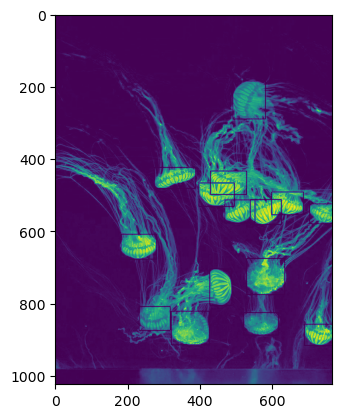

: 

In [6]:
import torch, cv2, os
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from pycocotools.coco import COCO
from torchvision import datasets
import matplotlib.pyplot as plt
import copy

def show(imags, coordinates):
    out_imgs = []
    for img, coords in zip(imags, coordinates):
        img = img.detach().cpu().numpy()[0]
        coords = tuple(list(coords.values())[0])
        labelled_img = img.copy()
        for c in coords:
            c = c.detach().cpu().numpy()
            cv2.rectangle(labelled_img, (int(c[0]), int(c[1])), (int(c[2]), int(c[3])), (0,0,0), 2)
        out_imgs.append(labelled_img)
    return out_imgs

def collate_fn(batch):
    return tuple(zip(*batch))

class Fish(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
            image = transformed['image']
            boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return torch.permute(torch.tensor(image/255.0).to(torch.float), (2,0,1)), targ # scale images
    def __len__(self):
        return len(self.ids)
    
if __name__ == "__main__":
    fish = Fish("/data_hdd1/hassan/projects/acquarium/data/acqurium", split='train')
    train_loader = DataLoader(fish, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
    for i, (images, targets) in enumerate(train_loader):
        imags = []
        for i in images:
                imags.append(i)
        for i in range(len(targets)):
            for k, v in targets[i].items():
                targets[i][k] = v
    bb_img = show(imags, targets)
    plt.imshow(bb_img[0])